In [1]:
# util
import pandas as pd
import numpy as np
import pickle

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Load Clean Data

In [2]:
%%time
files = "data\clean_twitter_sentimen.csv" 
chunk = pd.read_csv(files, chunksize=100000, encoding='ISO-8859-1')
df = pd.concat(chunk).sample(frac=1, random_state=42).reset_index(drop=True).dropna()

Wall time: 6.13 s


In [3]:
print(df.shape)
df.head()

(1591981, 3)


,target,text,cleaned_text
0,NEGATIVE,internet is slow on me today likes,internet slow today like
1,POSITIVE,"@tooclevername to those with hammers, everythi...",hammer everything look like nail
2,NEGATIVE,These kids are crazy save me,kid crazy save
3,NEGATIVE,my puppy libby scratched my heel and now it's...,puppy libby scratched heel bleeding got bandaid
4,POSITIVE,"okay, my ipod has been synced. FINALLY. so hap...",okay ipod synced finally happy anywho painting...


# Modelling

In [15]:
x = df['cleaned_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=42)

In [17]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit_transform(X_train)

train_x_vector = vectorizer.transform(X_train)
test_x_vector =  vectorizer.transform(X_test)

In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(test_x_vector)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Naive Bayes

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.76      0.77     79652
    POSITIVE       0.77      0.80      0.78     79547

    accuracy                           0.78    159199
   macro avg       0.78      0.78      0.78    159199
weighted avg       0.78      0.78      0.78    159199

Wall time: 13.1 s


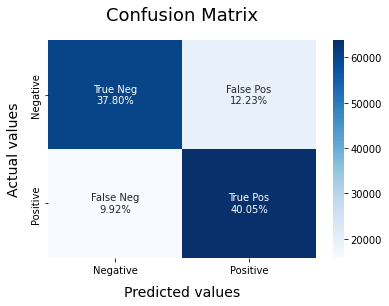

In [ ]:
%%time
BNBmodel = BernoulliNB(alpha=1)
BNBmodel.fit(train_x_vector, y_train)
model_Evaluate(BNBmodel)

# SVM Linear

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.77      0.78     79652
    POSITIVE       0.78      0.80      0.79     79547

    accuracy                           0.78    159199
   macro avg       0.78      0.78      0.78    159199
weighted avg       0.78      0.78      0.78    159199

Wall time: 2min 36s


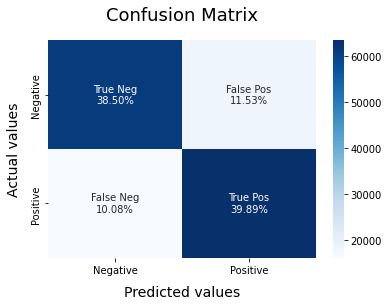

In [ ]:
%%time
from sklearn.calibration import CalibratedClassifierCV

SVCmodel = CalibratedClassifierCV(LinearSVC())
SVCmodel.fit(train_x_vector, y_train)
model_Evaluate(SVCmodel)

# Logistic Regression

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79     79652
    POSITIVE       0.79      0.81      0.80     79547

    accuracy                           0.79    159199
   macro avg       0.79      0.79      0.79    159199
weighted avg       0.80      0.79      0.79    159199

Wall time: 3min 22s


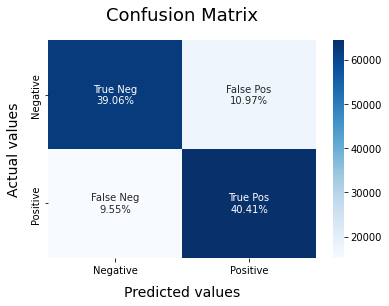

In [ ]:
%%time
LRmodel = LogisticRegression(C=2, max_iter=10000)
LRmodel.fit(train_x_vector, y_train)
model_Evaluate(LRmodel)

## DEMO

In [ ]:
# Local Packages
from packages.text import cleaning, flat

inputs = "hi i love you so much"
cleaning = cleaning(inputs)
X_test = vectorizer.transform([cleaning])

for model in [LRmodel, SVCmodel, BNBmodel]:
    print(f"==={model}===")
    print(f'text: {cleaning}')
    sentiment = model.predict(X_test)
    sentiment_proba = model.predict_proba(X_test)
    print(f'sentiment: {"".join(sentiment)}')
    print(f'probability: {round(max(flat(sentiment_proba)),3)}')
    print('\n')

===LogisticRegression(C=2, max_iter=1000)===
text: hi love much
sentiment: POSITIVE
probability: 0.89


===CalibratedClassifierCV(base_estimator=LinearSVC())===
text: hi love much
sentiment: POSITIVE
probability: 0.813


===BernoulliNB(alpha=1)===
text: hi love much
sentiment: POSITIVE
probability: 0.991




---
# TUNNING PARAMETER


In [18]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method =  RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

LRmodel = LogisticRegression(C=2, max_iter=10000)
SVCmodel = CalibratedClassifierCV(LinearSVC())
BNBmodel = BernoulliNB(alpha=1)

pipe = Pipeline([("classifier", BNBmodel)])

params = [
    {'classifier': [BNBmodel]},
    {'classifier': [SVCmodel]},
    {'classifier': [LRmodel]}
]

GS = GridSearchCV(pipe, param_grid=params, cv=cv_method, verbose=10, scoring='accuracy', n_jobs=-1)
GS.fit(train_x_vector, y_train)

Fitting 15 folds for each of 3 candidates, totalling 45 fits
Wall time: 42min 2s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('classifier', BernoulliNB(alpha=1))]),
             n_jobs=-1,
             param_grid=[{'classifier': [BernoulliNB(alpha=1)]},
                         {'classifier': [CalibratedClassifierCV(base_estimator=LinearSVC())]},
                         {'classifier': [LogisticRegression(C=2,
                                                            max_iter=10000)]}],
             scoring='accuracy', verbose=10)

In [19]:
GS.best_params_

{'classifier': LogisticRegression(C=2, max_iter=10000)}

In [20]:
print(f'Train Accuracy: {GS.best_estimator_.score(train_x_vector, y_train)}')
print(f'Test Accuracy: {GS.best_estimator_.score(test_x_vector, y_test)}')
print(classification_report(y_test, GS.best_estimator_.predict(test_x_vector)))

Train Accuracy: 0.849833474501465
Test Accuracy: 0.7970854271356784
              precision    recall  f1-score   support

    NEGATIVE       0.81      0.78      0.79     39804
    POSITIVE       0.79      0.81      0.80     39796

    accuracy                           0.80     79600
   macro avg       0.80      0.80      0.80     79600
weighted avg       0.80      0.80      0.80     79600



# SAVING FILES

In [ ]:
# Models
models = {
    "LRmodel": LRmodel,
    "SVCmodel": SVCmodel,
    "BNBmodel": BNBmodel
}
file =  open('CombineModel.pkl', 'wb')
pickle.dump(models, file)
file.close()

# Vectorizer
file = open('vectorizer.pkl', 'wb')
pickle.dump(vectorizer, file)
file.close()